# Model making

Create full data set for all states and don't exclude TN 

read cancer data set: state, county, avg_cost
income data - create income agg data by state and county


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from cm import plot_confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
#import graphviz
from IPython.display import SVG

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#Create a DataFrame, ha_costs_df, from the mmd_heart_attack_data.csv file.
ha_costs_df = pd.read_csv('../data/mmd_heart_attack_data.csv')
#Look at the head and tail of the DataFrame
ha_costs_df.head(-1)
ha_costs_df['state'].value_counts()
ha_costs_df.rename(columns = {'analysis_value': 'ha_avg_cost'}, inplace = True)
ha_costs_df.head(1)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,ha_avg_cost
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,Acute myocardial infarction,All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,40470


In [3]:
ha_costs_df.shape

(2656, 17)

In [4]:
#Create a DataFrame, cancer_costs_df, from the mmd_cancer_data.csv file.
cancer_costs_df = pd.read_csv('../data/mmd_cancer_data.csv')
#Look at the head and tail of the DataFrame
cancer_costs_df.head(-1)
cancer_costs_df['state'].value_counts()
cancer_costs_df.rename(columns = {'analysis_value': 'cancer_avg_cost'}, inplace = True)
cancer_costs_df.head(1)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,cancer_avg_cost
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,"Cancer, Colorectal, Breast, Prostate, Lung",All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,19293


In [5]:
cancer_costs_df.shape

(3165, 17)

In [6]:
#Create a DataFrame, income_df, from the irs_county_2016.csv file.
income_df = pd.read_csv('../data/irs_county_2016.csv')
income_df.info()
income_df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25536 entries, 0 to 25535
Columns: 148 entries, STATEFIPS to A11902
dtypes: int64(146), object(2)
memory usage: 28.8+ MB


,STATEFIPS,STATE,COUNTYFIPS,COUNTYNAME,agi_stub,N1,mars1,MARS2,MARS4,PREP,...,N10300,A10300,N85530,A85530,N85300,A85300,N11901,A11901,N11902,A11902
0,1,AL,0,Alabama,1,26450,14680,9740,680,17780,...,4300,9256,70,57,0,0,2590,3685,11510,35079


In [7]:
income_df.shape

(25536, 148)

In [8]:
#Keep only the following columns:
    #['STATE', 'COUNTYNAME', 'agi_stub', 'N1', 'mars1', 'MARS2', 'MARS4', 'N2', 'NUMDEP', 'ELDERLY', 'A00100', 'N02650', 'A02650', 'N02300', 'A02300']
income_df = income_df.loc[:, ['STATE', 'COUNTYNAME', 'agi_stub', 'N1', 'mars1', 'MARS2', 'MARS4', 'N2', 
                              'NUMDEP', 'ELDERLY','A00100', 'N02650', 'A02650', 'N02300', 'A02300']]

In [9]:
#Rename columns
income_df.columns = ['state', 'county', 'income_bucket', 'return_count', 'single_returns', 
                     'joint_returns', 'head_of_house_returns', 'exemptions', 'dependents', 
                     'elderly', 'agi', 'returns_with_total_inc','total_inc_amt', 'returns_with_unemployment', 
                     'unemployment_comp']
income_df.head(1)

,state,county,income_bucket,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp
0,AL,Alabama,1,26450,14680,9740,680,40700,5590,13000,-1679314,19140,-1657452,60,203


In [10]:
# Create agg income by state and county.
income_county_agg = income_df.groupby(['state', 'county']).sum() 
income_county_agg.head(1)

,,income_bucket,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp
state,county,,,,,,,,,,,,,
AK,Alaska,36,348070,175480,126660,37340,654950,205660,71410,23514361,347600,23858011,83270,167460


In [11]:
#Be sure to also `reset_index()` so that our aggregated data is re-indexed to begin at 0. 
income_county_agg = income_county_agg.reset_index()
income_county_agg.head(1)

,state,county,income_bucket,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp
0,AK,Alaska,36,348070,175480,126660,37340,654950,205660,71410,23514361,347600,23858011,83270,167460


In [12]:
#DataFrame which gives the approximate average household income for each county. 
#Calculate this as 1000*`total_inc_amt` / `return_count
income_county_agg['approx_avg_income']= 1000 * income_county_agg['total_inc_amt']/income_county_agg['return_count']
income_county_agg.head(1)

,state,county,income_bucket,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp,approx_avg_income
0,AK,Alaska,36,348070,175480,126660,37340,654950,205660,71410,23514361,347600,23858011,83270,167460,68543.715345


In [13]:
#Import geographic new data set
geog_df = pd.read_csv('../data/geographic_profile_new.csv')
geog_df.head(1)

,state,county,Median Household Income (5y Average),Median Household Income for +7-person Households (5y Avg.),Median Household Income for 1-person Households (5y Avg.),Median Household Income for 2-person Households (5y Avg.),Median Household Income for 3-person Households (5y Avg.),Median Household Income for 4-person Households (5y Avg.),Median Household Income for 5-person Households (5y Avg.),Median Household Income for 6-person Households (5y Avg.),...,Percent of 3 Person Households with 3 Workers (5y Avg.),Percent of 3 Person Households with No Workers (5y Avg.),Percent of Senior Population Below Federal Poverty Level (1y Avg.),Percent of Senior Population Below Federal Poverty Level (5y Avg.),Percentage of Total Housing Units that are Vacant (1y Avg.),Percentage of Total Housing Units that are Vacant (5y Avg.),Senior Unemployment Rate (1y Avg.),Senior Unemployment Rate (5y Avg.),Unemployment Rate (1y Avg.),Unemployment Rate (5y Avg.)
0,AL,Autauga County,53099.0,104659.0,26834.0,58452.0,76406.0,74429.0,73017.0,81500.0,...,0.101183,0.10611,NaN,0.061893,NaN,0.083869,NaN,0.079755,NaN,0.055252


In [14]:
#Import geographic new data set
health_outcomes = pd.read_excel('../data/2018 County Health Rankings Data - v2.xls', sheet_name = 5, header = [0,1])
health_outcomes.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0  \
                FIPS              State             County   
0               1001            Alabama            Autauga   
1               1003            Alabama            Baldwin   
2               1005            Alabama            Barbour   
3               1007            Alabama               Bibb   
4               1009            Alabama             Blount   

  Premature age-adjusted mortality                                      \
                          # Deaths Age-Adjusted Mortality 95% CI - Low   
0                            827.0                  449.6        418.5   
1                           2753.0                  351.3        337.5   
2                            418.0                  433.6        390.5   
3                            408.0                  529.1        476.7   
4                            996.0                  480.2        449.2   

                                                \
  95% CI - High Age-Adjusted Mortality (Black)   
0         480.7                          531.7   
1         365.1                          517.8   
2         476.6                          477.0   
3         581.4                          630.4   
4         511.2                            NaN   

                                                                    ...  \
  Age-Adjusted Mortality (Hispanic) Age-Adjusted Mortality (White)  ...   
0                               NaN                          444.9  ...   
1                             111.1                          349.3  ...   
2                               NaN                          394.7  ...   
3                               NaN                          526.6  ...   
4                               NaN                            NaN  ...   

  Demographics                                            \
    % Hispanic # Non-Hispanic White % Non-Hispanic White   
0     2.688754                41562            75.000000   
1     4.416411               173529            83.202198   
2     4.213364                12061            46.450992   
3     2.499669                16850            74.415934   
4     9.068695                50472            87.467073   

                                                                        \
  # Not Proficient in English % Not Proficient in English 95% CI - Low   
0                         432                    0.832739     0.457689   
1                        1540                    0.818809     0.508623   
2                         382                    1.519370     0.790980   
3                          96                    0.448137     0.000000   
4                        1018                    1.878506     1.332987   

                                                
  95% CI - High   % Female  # Rural    % Rural  
0      1.207789  51.288437  22921.0  42.002162  
1      1.128996  51.457833  77060.0  42.279099  
2      2.247760  46.932409  18613.0  67.789635  
3      1.041411  46.363114  15663.0  68.352607  
4      2.424025  50.613476  51562.0  89.951502  

[5 rows x 99 columns]

In [15]:
# First, combine the two column name levels
col_names = [' '.join(col).strip() for col in health_outcomes.columns.values]

# Then get rid of the "Unnamed" portion for the first 3 columns
col_names[0:3] = ['FIPS', 'state', 'county']
col_names

['FIPS',
 'state',
 'county',
 'Premature age-adjusted mortality # Deaths',
 'Premature age-adjusted mortality Age-Adjusted Mortality',
 'Premature age-adjusted mortality 95% CI - Low',
 'Premature age-adjusted mortality 95% CI - High',
 'Premature age-adjusted mortality Age-Adjusted Mortality (Black)',
 'Premature age-adjusted mortality Age-Adjusted Mortality (Hispanic)',
 'Premature age-adjusted mortality Age-Adjusted Mortality (White)',
 'Child mortality # Deaths',
 'Child mortality Child Mortality Rate',
 'Child mortality 95% CI - Low',
 'Child mortality 95% CI - High',
 'Child mortality Child Mortality Rate (Black)',
 'Child mortality Child Mortality Rate (Hispanic)',
 'Child mortality Child Mortality Rate (White)',
 'Infant mortality # Deaths',
 'Infant mortality Infant Mortality Rate',
 'Infant mortality 95% CI - Low',
 'Infant mortality 95% CI - High',
 'Infant mortality Infant Mortality Rate (Black)',
 'Infant mortality Infant Mortality Rate (Hispanic)',
 'Infant mortality Inf

In [16]:
health_outcomes.columns = col_names
health_outcomes.head()

,FIPS,state,county,Premature age-adjusted mortality # Deaths,Premature age-adjusted mortality Age-Adjusted Mortality,Premature age-adjusted mortality 95% CI - Low,Premature age-adjusted mortality 95% CI - High,Premature age-adjusted mortality Age-Adjusted Mortality (Black),Premature age-adjusted mortality Age-Adjusted Mortality (Hispanic),Premature age-adjusted mortality Age-Adjusted Mortality (White),...,Demographics % Hispanic,Demographics # Non-Hispanic White,Demographics % Non-Hispanic White,Demographics # Not Proficient in English,Demographics % Not Proficient in English,Demographics 95% CI - Low,Demographics 95% CI - High,Demographics % Female,Demographics # Rural,Demographics % Rural
0,1001,Alabama,Autauga,827.0,449.6,418.5,480.7,531.7,NaN,444.9,...,2.688754,41562,75.000000,432,0.832739,0.457689,1.207789,51.288437,22921.0,42.002162
1,1003,Alabama,Baldwin,2753.0,351.3,337.5,365.1,517.8,111.1,349.3,...,4.416411,173529,83.202198,1540,0.818809,0.508623,1.128996,51.457833,77060.0,42.279099
2,1005,Alabama,Barbour,418.0,433.6,390.5,476.6,477.0,NaN,394.7,...,4.213364,12061,46.450992,382,1.519370,0.790980,2.247760,46.932409,18613.0,67.789635
3,1007,Alabama,Bibb,408.0,529.1,476.7,581.4,630.4,NaN,526.6,...,2.499669,16850,74.415934,96,0.448137,0.000000,1.041411,46.363114,15663.0,68.352607
4,1009,Alabama,Blount,996.0,480.2,449.2,511.2,NaN,NaN,NaN,...,9.068695,50472,87.467073,1018,1.878506,1.332987,2.424025,50.613476,51562.0,89.951502


Merge heart attack and cancer data sets

In [17]:
cancer_costs_df.head(1)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,cancer_avg_cost
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,"Cancer, Colorectal, Breast, Prostate, Lung",All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,19293


In [18]:
ha_costs_df.head(1)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,ha_avg_cost
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,Acute myocardial infarction,All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,40470


In [19]:
ha_cancer_costs_df = pd.merge(cancer_costs_df.loc[:,['state', 'county', 'urban', 'cancer_avg_cost']], 
                                     ha_costs_df.loc[:,['state', 'county', 'ha_avg_cost']], on=['state', 'county'], how='inner')
ha_cancer_costs_df.head(1)

,state,county,urban,cancer_avg_cost,ha_avg_cost
0,ALABAMA,Autauga County,Urban,19293,40470


In [20]:
ha_cancer_costs_df.shape

(2656, 5)

In [21]:
##Create `state_dict`, a dictionary that uses the provides descripton of state abbreviation
#import state abbreviation dataset
state_abb_df = pd.read_csv('../data/state_abbrev.csv')
state_abb_df.head(1)

,name,abbrev
0,ALABAMA,AL


In [22]:
ha_cancer_costs_df.head()

,state,county,urban,cancer_avg_cost,ha_avg_cost
0,ALABAMA,Autauga County,Urban,19293,40470
1,ALABAMA,Baldwin County,Rural,17151,36615
2,ALABAMA,Barbour County,Rural,19469,46509
3,ALABAMA,Bibb County,Urban,17234,42949
4,ALABAMA,Blount County,Urban,20317,50067


In [23]:
ha_cancer_costs_df['state']=ha_cancer_costs_df.state.map(state_abb_df.set_index('name')['abbrev'].to_dict())

In [24]:
ha_cancer_costs_df.head(1)

,state,county,urban,cancer_avg_cost,ha_avg_cost
0,AL,Autauga County,Urban,19293,40470


In [25]:
income_county_agg.head(1)

,state,county,income_bucket,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp,approx_avg_income
0,AK,Alaska,36,348070,175480,126660,37340,654950,205660,71410,23514361,347600,23858011,83270,167460,68543.715345


In [26]:
ha_cancer_costs_incomeavg_df = pd.merge(ha_cancer_costs_df, 
                                        income_county_agg.loc[:,['state', 'county', 'approx_avg_income', 'agi', 'income_bucket']], on=['state', 'county'], how='inner')
ha_cancer_costs_incomeavg_df.head(1)

,state,county,urban,cancer_avg_cost,ha_avg_cost,approx_avg_income,agi,income_bucket
0,AL,Autauga County,Urban,19293,40470,55680.240764,1327941,36


In [27]:
ha_cancer_costs_incomeavg_df.shape

(2619, 8)

In [317]:
geog_df.head(1)

,state,county,Median Household Income (5y Average),Median Household Income for +7-person Households (5y Avg.),Median Household Income for 1-person Households (5y Avg.),Median Household Income for 2-person Households (5y Avg.),Median Household Income for 3-person Households (5y Avg.),Median Household Income for 4-person Households (5y Avg.),Median Household Income for 5-person Households (5y Avg.),Median Household Income for 6-person Households (5y Avg.),...,Percent of 3 Person Households with 3 Workers (5y Avg.),Percent of 3 Person Households with No Workers (5y Avg.),Percent of Senior Population Below Federal Poverty Level (1y Avg.),Percent of Senior Population Below Federal Poverty Level (5y Avg.),Percentage of Total Housing Units that are Vacant (1y Avg.),Percentage of Total Housing Units that are Vacant (5y Avg.),Senior Unemployment Rate (1y Avg.),Senior Unemployment Rate (5y Avg.),Unemployment Rate (1y Avg.),Unemployment Rate (5y Avg.)
0,AL,Autauga County,53099.0,104659.0,26834.0,58452.0,76406.0,74429.0,73017.0,81500.0,...,0.101183,0.10611,NaN,0.061893,NaN,0.083869,NaN,0.079755,NaN,0.055252


In [318]:
ha_cancer_costs_incomeavg_geog_df = pd.merge(ha_cancer_costs_incomeavg_df, 
                                        geog_df.loc[:,['state', 'county', 'Unemployment Rate (5y Avg.)', 
                                                       'Percent Below Federal Poverty Level (5y Avg.)', 
                                                       'Percent of Senior Population Below Federal Poverty Level (5y Avg.)',
                                                      'Senior Unemployment Rate (5y Avg.)',
                                                      'Median Household Income (5y Average)']], 
                                             on=['state', 'county'], how='inner')
ha_cancer_costs_incomeavg_geog_df.head(1)

,state,county,urban,cancer_avg_cost,ha_avg_cost,approx_avg_income,agi,income_bucket,Unemployment Rate (5y Avg.),Percent Below Federal Poverty Level (5y Avg.),Percent of Senior Population Below Federal Poverty Level (5y Avg.),Senior Unemployment Rate (5y Avg.),Median Household Income (5y Average)
0,AL,Autauga County,Urban,19293,40470,55680.240764,1327941,36,0.055252,0.12266,0.061893,0.079755,53099.0


In [319]:
ha_cancer_costs_incomeavg_geog_df.shape

(2618, 13)

In [320]:
#Creating specific demographic data from health outcomes dataset, which will be used in merge
health_outcomes_1 = health_outcomes[['state', 'county', 'Demographics % Hispanic', 'Demographics % Female',
                                     'Uninsured adults # Uninsured', 'Frequent physical distress % Frequent Physical Distress',
                                                      'Uninsured adults % Uninsured',
                                    'Frequent mental distress % Frequent Mental Distress',
                                    'Demographics % Not Proficient in English',
                                    'Diabetes prevalence % Diabetic',
                                     'Food insecurity % Food Insecure',
                                     'Insufficient sleep % Insufficient Sleep',
                                     'Demographics % African American',
                                     'Limited access to healthy foods % Limited Access']]
health_outcomes_1.head(2)

,state,county,Demographics % Hispanic,Demographics % Female,Uninsured adults # Uninsured,Frequent physical distress % Frequent Physical Distress,Uninsured adults % Uninsured,Frequent mental distress % Frequent Mental Distress,Demographics % Not Proficient in English,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,Insufficient sleep % Insufficient Sleep,Demographics % African American,Limited access to healthy foods % Limited Access
0,Alabama,Autauga,2.688754,51.288437,4102.0,12.824434,12.193092,12.638357,0.832739,12.4,13.9,35.905406,19.048650,11.991125
1,Alabama,Baldwin,4.416411,51.457833,17437.0,12.622002,14.719861,12.822558,0.818809,11.1,13.0,33.305868,9.042831,5.424427


In [321]:
#chnaging the state name to abreviation format to ensure merge is successful
health_outcomes_1['state']=health_outcomes_1.state.str.upper().map(state_abb_df.set_index('name')['abbrev'].to_dict())
health_outcomes_1.head(1)

,state,county,Demographics % Hispanic,Demographics % Female,Uninsured adults # Uninsured,Frequent physical distress % Frequent Physical Distress,Uninsured adults % Uninsured,Frequent mental distress % Frequent Mental Distress,Demographics % Not Proficient in English,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,Insufficient sleep % Insufficient Sleep,Demographics % African American,Limited access to healthy foods % Limited Access
0,AL,Autauga,2.688754,51.288437,4102.0,12.824434,12.193092,12.638357,0.832739,12.4,13.9,35.905406,19.04865,11.991125


In [322]:
#Adding County in the County column to ensure merge is successfull
health_outcomes_1.county = health_outcomes_1.county + ' County'

In [323]:
ha_cancer_costs_incomeavg_geog_1_df = pd.merge(ha_cancer_costs_incomeavg_geog_df, 
                                        health_outcomes_1, 
                                             on=['state', 'county'], how='inner')
ha_cancer_costs_incomeavg_geog_1_df.head(1)

,state,county,urban,cancer_avg_cost,ha_avg_cost,approx_avg_income,agi,income_bucket,Unemployment Rate (5y Avg.),Percent Below Federal Poverty Level (5y Avg.),...,Uninsured adults # Uninsured,Frequent physical distress % Frequent Physical Distress,Uninsured adults % Uninsured,Frequent mental distress % Frequent Mental Distress,Demographics % Not Proficient in English,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,Insufficient sleep % Insufficient Sleep,Demographics % African American,Limited access to healthy foods % Limited Access
0,AL,Autauga County,Urban,19293,40470,55680.240764,1327941,36,0.055252,0.12266,...,4102.0,12.824434,12.193092,12.638357,0.832739,12.4,13.9,35.905406,19.04865,11.991125


In [324]:
ha_cancer_costs_incomeavg_geog_1_df.shape

(2524, 25)

In [325]:
ha_cancer_costs_incomeavg_geog_1_df['ha_cost_income_ratio'] = ha_cancer_costs_incomeavg_geog_1_df.ha_avg_cost / ha_cancer_costs_incomeavg_geog_1_df.approx_avg_income
ha_cancer_costs_incomeavg_geog_1_df['cancer_cost_income_ratio'] = ha_cancer_costs_incomeavg_geog_1_df.cancer_avg_cost / ha_cancer_costs_incomeavg_geog_1_df.approx_avg_income
ha_cancer_costs_incomeavg_geog_1_df.head(1)

,state,county,urban,cancer_avg_cost,ha_avg_cost,approx_avg_income,agi,income_bucket,Unemployment Rate (5y Avg.),Percent Below Federal Poverty Level (5y Avg.),...,Uninsured adults % Uninsured,Frequent mental distress % Frequent Mental Distress,Demographics % Not Proficient in English,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,Insufficient sleep % Insufficient Sleep,Demographics % African American,Limited access to healthy foods % Limited Access,ha_cost_income_ratio,cancer_cost_income_ratio
0,AL,Autauga County,Urban,19293,40470,55680.240764,1327941,36,0.055252,0.12266,...,12.193092,12.638357,0.832739,12.4,13.9,35.905406,19.04865,11.991125,0.726829,0.346496


In [326]:
ha_cancer_costs_incomeavg_geog_1_df.cancer_cost_income_ratio.mean()


0.4085212122276527

In [327]:
ha_cancer_costs_incomeavg_geog_1_df['condition'] = ha_cancer_costs_incomeavg_geog_1_df.cancer_cost_income_ratio.mean()
ha_cancer_costs_incomeavg_geog_1_df.head(1)

,state,county,urban,cancer_avg_cost,ha_avg_cost,approx_avg_income,agi,income_bucket,Unemployment Rate (5y Avg.),Percent Below Federal Poverty Level (5y Avg.),...,Frequent mental distress % Frequent Mental Distress,Demographics % Not Proficient in English,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,Insufficient sleep % Insufficient Sleep,Demographics % African American,Limited access to healthy foods % Limited Access,ha_cost_income_ratio,cancer_cost_income_ratio,condition
0,AL,Autauga County,Urban,19293,40470,55680.240764,1327941,36,0.055252,0.12266,...,12.638357,0.832739,12.4,13.9,35.905406,19.04865,11.991125,0.726829,0.346496,0.408521


In [328]:
#creating depedendent variable
#average cost for cancer care is above the average cost or equal to or below the average cost
ha_cancer_costs_incomeavg_geog_1_df['cancer_cost_income_ratio_above_avg_y'] = ha_cancer_costs_incomeavg_geog_1_df.cancer_cost_income_ratio > ha_cancer_costs_incomeavg_geog_1_df.condition
ha_cancer_costs_incomeavg_geog_1_df.head(1)

,state,county,urban,cancer_avg_cost,ha_avg_cost,approx_avg_income,agi,income_bucket,Unemployment Rate (5y Avg.),Percent Below Federal Poverty Level (5y Avg.),...,Demographics % Not Proficient in English,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,Insufficient sleep % Insufficient Sleep,Demographics % African American,Limited access to healthy foods % Limited Access,ha_cost_income_ratio,cancer_cost_income_ratio,condition,cancer_cost_income_ratio_above_avg_y
0,AL,Autauga County,Urban,19293,40470,55680.240764,1327941,36,0.055252,0.12266,...,0.832739,12.4,13.9,35.905406,19.04865,11.991125,0.726829,0.346496,0.408521,False


In [329]:
#get dummmies
ha_cancer_costs_incomeavg_geog_1_df = pd.get_dummies(ha_cancer_costs_incomeavg_geog_1_df, columns = ['urban'], drop_first = True)

In [330]:
ha_cancer_costs_incomeavg_geog_1_df.head(1)

,state,county,cancer_avg_cost,ha_avg_cost,approx_avg_income,agi,income_bucket,Unemployment Rate (5y Avg.),Percent Below Federal Poverty Level (5y Avg.),Percent of Senior Population Below Federal Poverty Level (5y Avg.),...,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,Insufficient sleep % Insufficient Sleep,Demographics % African American,Limited access to healthy foods % Limited Access,ha_cost_income_ratio,cancer_cost_income_ratio,condition,cancer_cost_income_ratio_above_avg_y,urban_Urban
0,AL,Autauga County,19293,40470,55680.240764,1327941,36,0.055252,0.12266,0.061893,...,12.4,13.9,35.905406,19.04865,11.991125,0.726829,0.346496,0.408521,False,1


In [342]:
#log reg model
X = ha_cancer_costs_incomeavg_geog_1_df[['urban_Urban',
                                        'Uninsured adults % Uninsured',
                                        'Frequent physical distress % Frequent Physical Distress',
                                         'Diabetes prevalence % Diabetic',
                                         'Food insecurity % Food Insecure'
                                         ]]
#tested these variables: 
#'Insufficient sleep % Insufficient Sleep',  'Demographics % African American', 'Median Household Income (5y Average)',                                     
#'ha_cost_income_ratio', 'Frequent mental distress % Frequent Mental Distress', 'Demographics % Not Proficient in English'
#'Percent Below Federal Poverty Level (5y Avg.)','Demographics % Hispanic',  'Demographics % Female' 
#'Senior Unemployment Rate (5y Avg.)']]
y = ha_cancer_costs_incomeavg_geog_1_df['cancer_cost_income_ratio_above_avg_y']

In [343]:
logistic_model = LogisticRegression()
logistic_model.fit(X, y)

LogisticRegression()

In [344]:
logistic_model.coef_[0]

array([-1.17697018,  0.02961913,  0.46116873,  0.11549581,  0.03687876])

In [345]:
#Machine learning
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321)

In [346]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

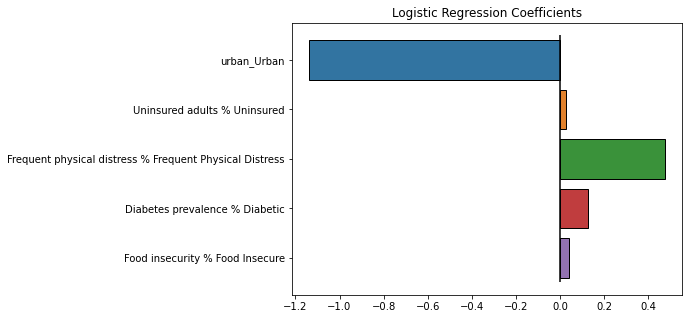

In [347]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(x = logistic_model.coef_[0], y = list(X.columns), ax = ax, edgecolor = 'black')
plt.title('Logistic Regression Coefficients')

ymin, ymax = plt.ylim()
plt.vlines(x = 0, ymin = ymin, ymax = ymax);

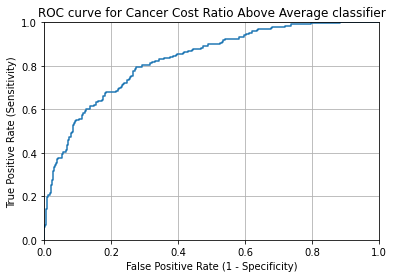

In [348]:
y_pred_prob = logistic_model.predict_proba(X_test)[:,1]
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fp_rate, tp_rate)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Cancer Cost Ratio Above Average classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [349]:
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.8296059637912673


In [350]:
#Model accuracy (Full Model)
y_pred = logistic_model.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.7416798732171157

# Performing Descriptives for the presentaiotn for TN STATE ONLY!!!

important variables for Cancer cost ratio based on whole US Data:
1. heart attack cost
2. Urban
3. Percent Below Federal Poverty Level (5y Avg.) 
4. Senior Unemployment Rate (5y Avg.)
Females and Hispanics don't matter! We can show it

In [305]:
ha_cancer_costs_incomeavg_geog_1_df.head(1)

,state,county,cancer_avg_cost,ha_avg_cost,approx_avg_income,agi,income_bucket,Unemployment Rate (5y Avg.),Percent Below Federal Poverty Level (5y Avg.),Percent of Senior Population Below Federal Poverty Level (5y Avg.),...,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,Insufficient sleep % Insufficient Sleep,Demographics % African American,Limited access to healthy foods % Limited Access,ha_cost_income_ratio,cancer_cost_income_ratio,condition,cancer_cost_income_ratio_above_avg_y,urban_Urban
0,AL,Autauga County,19293,40470,55680.240764,1327941,36,0.055252,0.12266,0.061893,...,12.4,13.9,35.905406,19.04865,11.991125,0.726829,0.346496,0.408521,False,1


In [306]:
#Restrciting the data to TN State for presentation
TN_df = ha_cancer_costs_incomeavg_geog_1_df['state'] == 'TN'
TN_Full_df = ha_cancer_costs_incomeavg_geog_1_df[TN_df]
TN_Full_df.head(1)

,state,county,cancer_avg_cost,ha_avg_cost,approx_avg_income,agi,income_bucket,Unemployment Rate (5y Avg.),Percent Below Federal Poverty Level (5y Avg.),Percent of Senior Population Below Federal Poverty Level (5y Avg.),...,Diabetes prevalence % Diabetic,Food insecurity % Food Insecure,Insufficient sleep % Insufficient Sleep,Demographics % African American,Limited access to healthy foods % Limited Access,ha_cost_income_ratio,cancer_cost_income_ratio,condition,cancer_cost_income_ratio_above_avg_y,urban_Urban
1950,TN,Anderson County,15454,42749,53382.385535,1807309,36,0.073644,0.172117,0.077402,...,11.7,14.4,35.819313,3.954646,9.359187,0.800807,0.289496,0.408521,False,1


In [307]:
TN_Full_df.shape

(91, 28)

<Figure size 1080x720 with 0 Axes>

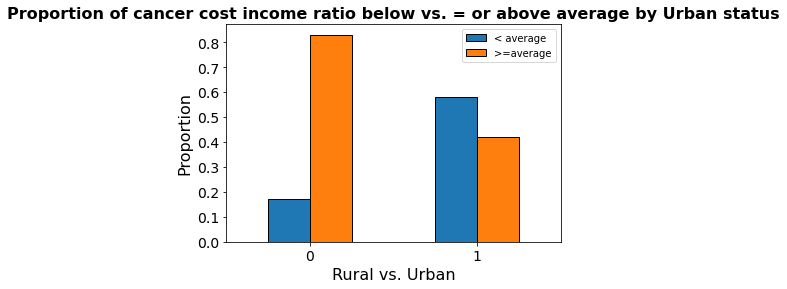

In [379]:
#Perfroming explorating analysis for important variables identified by full US dataset
plt.figure(figsize = (15, 10))
pd.crosstab(TN_Full_df['urban_Urban'], TN_Full_df['cancer_cost_income_ratio_above_avg_y'], 
            normalize='index').plot(kind = 'bar', edgecolor = 'black')
plt.xticks(rotation = 0, fontsize = 14)
plt.xlabel('Rural vs. Urban', fontsize = 16)
plt.ylabel('Proportion', fontsize = 16)
plt.yticks(fontsize = 14)
plt.legend(loc = 'upper right', labels = ['< average', '>=average'])
plt.title('Proportion of cancer cost income ratio below vs. = or above average by Urban status', fontsize = 16, fontweight = 'bold');

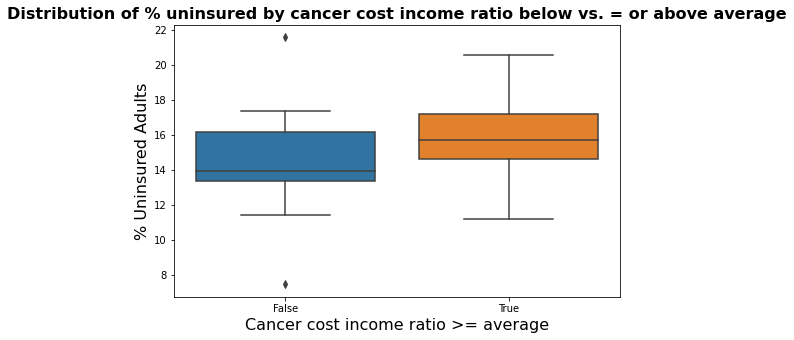

In [391]:
plt.figure(figsize = (8, 5))
sns.boxplot(y=TN_Full_df['Uninsured adults % Uninsured'], x = TN_Full_df['cancer_cost_income_ratio_above_avg_y'])
plt.xlabel('Cancer cost income ratio >= average', fontsize = 16)
plt.ylabel('% Uninsured Adults', fontsize = 16)
plt.title('Distribution of % uninsured by cancer cost income ratio below vs. = or above average',
         fontsize = 16, fontweight = 'bold');
#plt.xlabel('')

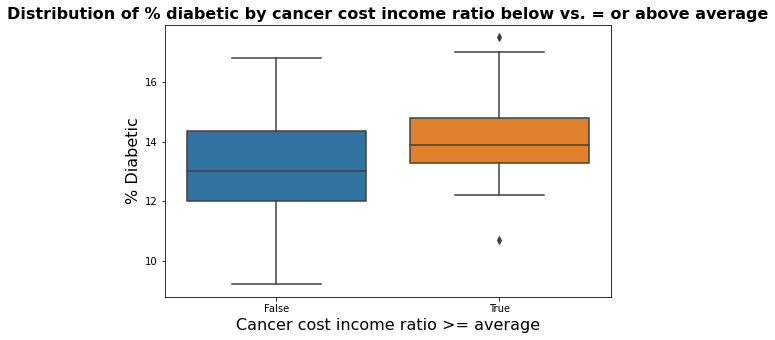

In [393]:
plt.figure(figsize = (8, 5))
sns.boxplot(y=TN_Full_df['Diabetes prevalence % Diabetic'], x = TN_Full_df['cancer_cost_income_ratio_above_avg_y'])
plt.xlabel('Cancer cost income ratio >= average', fontsize = 16)
plt.ylabel('% Diabetic', fontsize = 16)
plt.title('Distribution of % diabetic by cancer cost income ratio below vs. = or above average',
         fontsize = 16, fontweight = 'bold');
#plt.xlabel('')

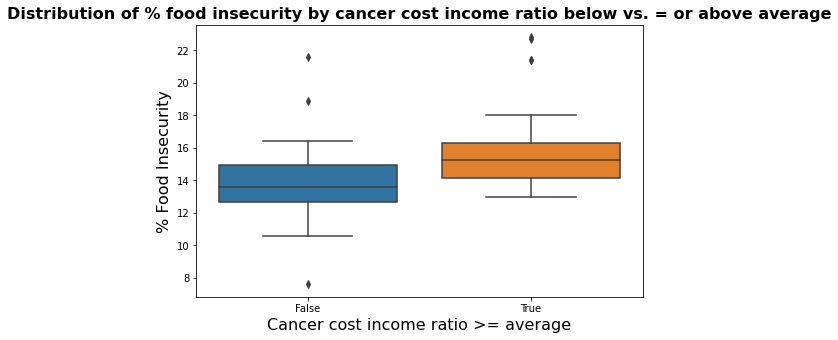

In [394]:
plt.figure(figsize = (8, 5))
sns.boxplot(y=TN_Full_df['Food insecurity % Food Insecure'], x = TN_Full_df['cancer_cost_income_ratio_above_avg_y'])
plt.xlabel('Cancer cost income ratio >= average', fontsize = 16)
plt.ylabel('% Food Insecurity', fontsize = 16)
plt.title('Distribution of % food insecurity by cancer cost income ratio below vs. = or above average',
         fontsize = 16, fontweight = 'bold');
#plt.xlabel('')


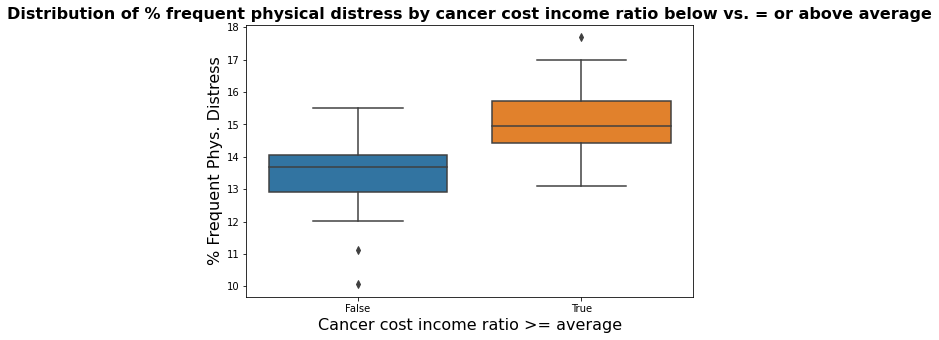

In [396]:
plt.figure(figsize = (8, 5))
sns.boxplot(y=TN_Full_df['Frequent physical distress % Frequent Physical Distress'], x = TN_Full_df['cancer_cost_income_ratio_above_avg_y'])
plt.xlabel('Cancer cost income ratio >= average', fontsize = 16)
plt.ylabel('% Frequent Phys. Distress', fontsize = 16)
plt.title('Distribution of % frequent physical distress by cancer cost income ratio below vs. = or above average',
         fontsize = 16, fontweight = 'bold');
#plt.xlabel('')

# End of code for presentation

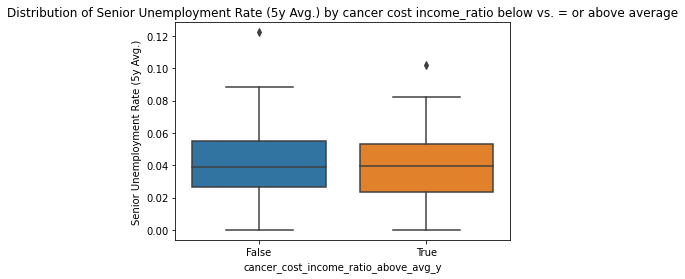

In [298]:
sns.boxplot(y=TN_Full_df['Senior Unemployment Rate (5y Avg.)'], x = TN_Full_df['cancer_cost_income_ratio_above_avg_y'])
plt.title('Distribution of Senior Unemployment Rate (5y Avg.) by cancer cost income_ratio below vs. = or above average');
#plt.xlabel('')

Build and evaluate a `RandomForestClassifier` 'NOT NEEDED FOR PRESENTATION'!

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

In [ ]:
y_pred_train = tree.predict(X_train)
print(metrics.accuracy_score(y_train, y_pred_train))

In [ ]:
y_pred = tree.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))

In [ ]:
forest = RandomForestClassifier(n_estimators = 1000, max_depth = 5, min_samples_leaf = 5)
forest.fit(X_train, y_train)

In [ ]:
y_pred_train = forest.predict(X_train)
print(metrics.accuracy_score(y_train, y_pred_train))

In [ ]:
y_pred = forest.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

In [ ]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(x = forest.feature_importances_, y = list(X.columns), ax = ax, edgecolor = 'black')
plt.title('Random Forest Feature Importance');